In [1]:
# %% Setup and Import
import numpy as np
from scipy.stats import lognorm, gaussian_kde
from scipy.optimize import minimize
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

np.random.seed(123)

In [2]:
# %% Literature definitions for nodule distributions
# Gould-style bins for largest nodule, 4–30 mm
edges = np.array([4, 5, 8, 12, 20, 30])

# Target proportions in each bin (conditional on 4–30 mm)
target_props = np.array([0.24, 0.21, 0.18, 0.22, 0.15])

target_props.sum()


np.float64(0.9999999999999999)

In [3]:
def truncated_lognorm_bin_probs(mu, log_sigma, edges):
    """
    Given meanlog=mu and log_sigma=log(sigma),
    return conditional bin probabilities over [edges[0], edges[-1]].
    """
    sigma = np.exp(log_sigma)
    dist = lognorm(s=sigma, scale=np.exp(mu))

    F_edges = dist.cdf(edges)

    # Normalizing constant over [4,30]
    Z = F_edges[-1] - F_edges[0]

    # Mirror the R behavior: if essentially zero mass in [4,30], kill it
    if (not np.isfinite(Z)) or (Z < 1e-6):
        return np.full(len(edges) - 1, np.nan)

    p_bins = np.diff(F_edges) / Z
    return p_bins


def objective(params, edges, target_props):
    mu, log_sigma = params
    p_bins = truncated_lognorm_bin_probs(mu, log_sigma, edges)
    if np.any(~np.isfinite(p_bins)):
        return 1e6
    return np.sum((p_bins - target_props) ** 2)


In [4]:
from scipy.optimize import minimize

mu_init = 2.3
log_sigma_init = np.log(0.6)

res = minimize(
    objective,
    x0=np.array([mu_init, log_sigma_init]),
    args=(edges, target_props),
    method="L-BFGS-B",
    bounds=[(1.0, 3.0), (np.log(0.2), np.log(1.5))],  # bounds on mu, log_sigma
    options={"maxiter": 2000, "disp": True}
)

mu_hat, log_sigma_hat = res.x
sigma_hat = np.exp(log_sigma_hat)

print("Fitted parameters:")
print(f"  meanlog (mu_hat)   = {mu_hat:.4f}")
print(f"  sdlog  (sigma_hat) = {sigma_hat:.4f}")

p_fit = truncated_lognorm_bin_probs(mu_hat, log_sigma_hat, edges)

print("\nBin matches (target vs fit):")
for i in range(len(target_props)):
    print(
        f"{edges[i]:>2.0f}–{edges[i+1]:<2.0f} mm: "
        f"target = {target_props[i]:.3f},  fit = {p_fit[i]:.3f}"
    )


Fitted parameters:
  meanlog (mu_hat)   = 1.4747
  sdlog  (sigma_hat) = 1.5000

Bin matches (target vs fit):
 4–5  mm: target = 0.240,  fit = 0.140
 5–8  mm: target = 0.210,  fit = 0.285
 8–12 mm: target = 0.180,  fit = 0.220
12–20 mm: target = 0.220,  fit = 0.224
20–30 mm: target = 0.150,  fit = 0.132


In [5]:
# %%
mu_hat, log_sigma_hat = res.x
sigma_hat = np.exp(log_sigma_hat)

print("Fitted parameters:")
print(f"  meanlog (mu_hat)   = {mu_hat:.4f}")
print(f"  sdlog  (sigma_hat) = {sigma_hat:.4f}")

p_fit = truncated_lognorm_bin_probs(mu_hat, log_sigma_hat, edges)

print("\nBin matches (target vs fit):")
for i in range(len(target_props)):
    print(
        f"{edges[i]:>2.0f}–{edges[i+1]:<2.0f} mm: "
        f"target = {target_props[i]:.3f},  fit = {p_fit[i]:.3f}"
    )


Fitted parameters:
  meanlog (mu_hat)   = 1.4747
  sdlog  (sigma_hat) = 1.5000

Bin matches (target vs fit):
 4–5  mm: target = 0.240,  fit = 0.140
 5–8  mm: target = 0.210,  fit = 0.285
 8–12 mm: target = 0.180,  fit = 0.220
12–20 mm: target = 0.220,  fit = 0.224
20–30 mm: target = 0.150,  fit = 0.132


In [6]:
# %%
def r_truncated_lognorm(n, meanlog, sdlog, xmin=4.0, xmax=30.0):
    """
    Fast truncated lognormal sampler:
    log(X) ~ N(meanlog, sdlog^2), truncated to [log(xmin), log(xmax)].
    """
    # sanity check: interval has non-negligible probability
    dist_full = lognorm(s=sdlog, scale=np.exp(meanlog))
    p_int = dist_full.cdf(xmax) - dist_full.cdf(xmin)
    if (not np.isfinite(p_int)) or (p_int < 1e-8):
        raise ValueError(
            f"Truncation [{xmin}, {xmax}] has essentially zero prob (p={p_int:.2e}) "
            f"under lognormal(meanlog={meanlog:.3f}, sdlog={sdlog:.3f})."
        )
    
    # transform to standard normal on log-scale
    a = (np.log(xmin) - meanlog) / sdlog
    b = (np.log(xmax) - meanlog) / sdlog
    
    # sample Z ~ N(0,1) truncated to [a,b]
    z = truncnorm.rvs(a, b, loc=0, scale=1, size=n)
    return np.exp(meanlog + sdlog * z)


In [7]:
# %%
N_all = 50000  # total PCP-world nodules (choose scale)

size_all = r_truncated_lognorm(
    n=N_all,
    meanlog=mu_hat,
    sdlog=sigma_hat,
    xmin=4.0,
    xmax=30.0
)

size_all_orig = size_all.copy()  # keep full PCP pool


In [8]:
# %%
N_lit = 10000

# choose bin index for each literature nodule
bin_ids = np.random.choice(
    np.arange(len(target_props)),
    size=N_lit,
    p=target_props
)

size_lit = np.empty(N_lit)
for i, b in enumerate(bin_ids):
    low = edges[b]
    high = edges[b + 1]
    size_lit[i] = np.random.uniform(low, high)

size_lit[:10]


array([ 7.57383115,  4.43829028,  8.15376091, 10.87661723, 10.17568467,
        6.15056876,  8.77747485,  4.23866547,  8.5563058 , 26.68618204])

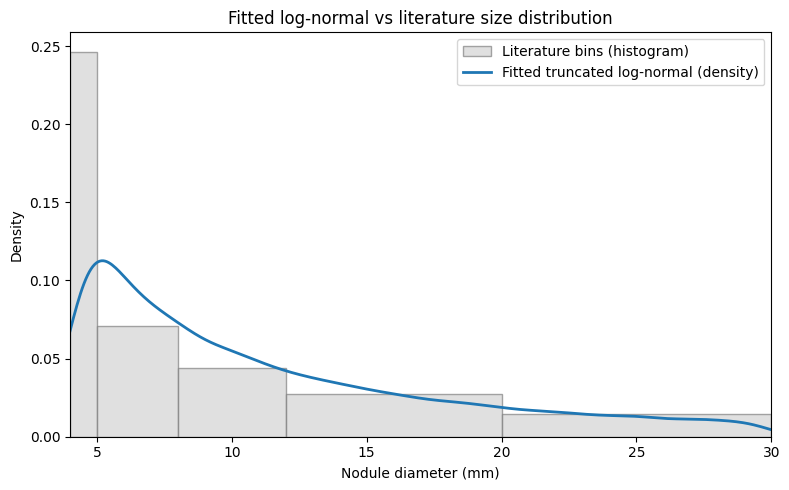

In [9]:
# %%
plt.figure(figsize=(8, 5))

# Literature histogram as density
plt.hist(
    size_lit,
    bins=edges,
    density=True,
    alpha=0.7,
    color="lightgray",
    edgecolor="gray",
    label="Literature bins (histogram)"
)

# Simulated density using KDE
kde = gaussian_kde(size_all)
x_vals = np.linspace(4, 30, 400)
y_vals = kde(x_vals)

plt.plot(
    x_vals,
    y_vals,
    linewidth=2,
    label="Fitted truncated log-normal (density)"
)

plt.xlabel("Nodule diameter (mm)")
plt.ylabel("Density")
plt.title("Fitted log-normal vs literature size distribution")
plt.xlim(4, 30)
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
# %%
import numpy as np
import pandas as pd
from scipy.special import expit, logit

# Literature / size bins: same as before
breaks_lit = np.array([4, 5, 8, 12, 20, 30])

# Malignancy probability per bin (R: probs_malig_lit)
probs_malig_lit = np.array([
    0.01,  # 4–<=5 mm
    0.03,  # >5–<=8 mm
    0.07,  # >8–<=12 mm
    0.15,  # >12–<=20 mm
    0.30   # >20–<=30 mm
])

assert len(probs_malig_lit) == len(breaks_lit) - 1

def malig_prob_from_size(size_mm):
    """
    Vectorized: assign malignancy probability by size bin.
    Out-of-range gets 0.
    """
    size_mm = np.asarray(size_mm)
    probs = np.zeros_like(size_mm, dtype=float)

    # bins: [4,5], (5,8], (8,12], (12,20], (20,30]
    for i in range(len(probs_malig_lit)):
        low = breaks_lit[i]
        high = breaks_lit[i+1]
        if i == 0:
            mask = (size_mm >= low) & (size_mm <= high)
        else:
            mask = (size_mm > low) & (size_mm <= high)
        probs[mask] = probs_malig_lit[i]

    return probs

# For all nodules in PCP pool:
p_all = malig_prob_from_size(size_all_orig)
rng = np.random.default_rng(123)

cancer_all = rng.binomial(1, p_all, size=len(size_all_orig))


In [13]:
# %%
# Clip probabilities to avoid logit(0) / logit(1)
p_eps = np.clip(p_all, 1e-6, 1 - 1e-6)
Mayo_log = logit(p_eps)

sim_data = pd.DataFrame({
    "y": cancer_all.astype(int),
    "Mayo_log": Mayo_log
})


In [14]:
# %%
from sklearn.metrics import roc_auc_score

RAD_Perf = "smallnodules"  # "low", "med", "high", "smallnodules"
RAD_mode = "Sens"          # "Balanced", "Spec", "Sens"

# Base AUC tuning
if RAD_Perf == "low":
    AUCnew = 0.73211 - 0.071
elif RAD_Perf == "med":
    AUCnew = 0.73211
elif RAD_Perf == "high":
    AUCnew = 0.73211 + 0.071
elif RAD_Perf == "smallnodules":
    AUCnew = 0.90
else:
    AUCnew = 0.73211

y = sim_data["y"].values
X_log = sim_data["Mayo_log"].values

def calibrate_sd_for_auc(y, X_log, auc_target, rng, sd_grid=np.linspace(0.1, 3.0, 30)):
    """
    Rough grid search for SD_radiomics in Balanced mode to hit AUCnew.
    Uses the same Z_x + noise structure as your R code.
    """
    best_sd = sd_grid[0]
    best_err = 1e9

    for sd in sd_grid:
        Radiomics = np.zeros_like(X_log)
        for grp in [0, 1]:
            idx = (y == grp)
            if not np.any(idx):
                continue
            X = X_log[idx]
            mu_x = X.mean()
            sd_x = X.std()
            Z_x = (X - mu_x) / sd_x
            noise = rng.normal(0, sd, size=idx.sum())
            Radiomics[idx] = Z_x + noise

        try:
            auc = roc_auc_score(y, Radiomics)
        except ValueError:
            continue

        err = abs(auc - auc_target)
        if err < best_err:
            best_err = err
            best_sd = sd

    return best_sd

rng = np.random.default_rng(456)

# Calibrate SD_radiomics for Balanced mode
SD_radiomics = calibrate_sd_for_auc(y, X_log, AUCnew, rng)
print("Calibrated SD_radiomics (Balanced):", SD_radiomics)

# Now generate Radiomics according to RAD_mode (group-specific tweaks)
Radiomics = np.zeros_like(X_log)

for grp in [0, 1]:
    idx = (y == grp)
    if not np.any(idx):
        continue
    X = X_log[idx]
    mu_x = X.mean()
    sd_x = X.std()
    Z_x = (X - mu_x) / sd_x

    if RAD_mode == "Balanced":
        group_sd = SD_radiomics
        noise = rng.normal(0, group_sd, size=idx.sum())

    elif RAD_mode == "Spec" and grp == 0:
        group_sd = SD_radiomics * 0.85
        noise = rng.normal(0, group_sd, size=idx.sum())

    elif RAD_mode == "Spec" and grp == 1:
        group_sd = SD_radiomics * 1.5
        # heavy tails via t(df=3), scaled to sd = group_sd
        t_raw = rng.standard_t(df=3, size=idx.sum())
        noise = t_raw * (group_sd / np.sqrt(3.0))  # sd(t3) = sqrt(3)

    elif RAD_mode == "Sens" and grp == 1:
        group_sd = SD_radiomics * 0.7
        noise = rng.normal(0, group_sd, size=idx.sum())

    elif RAD_mode == "Sens" and grp == 0:
        group_sd = SD_radiomics * 1.65
        t_raw = rng.standard_t(df=3, size=idx.sum())
        noise = t_raw * (group_sd / np.sqrt(3.0))

    else:
        # default fallback
        group_sd = SD_radiomics
        noise = rng.normal(0, group_sd, size=idx.sum())

    Radiomics[idx] = Z_x + noise

sim_data["Radiomics"] = Radiomics

print("Radiomics AUC:",
      roc_auc_score(sim_data["y"], sim_data["Radiomics"]))


Calibrated SD_radiomics (Balanced): 0.4
Radiomics AUC: 0.5171509116741683


In [15]:
# %%
from sklearn.metrics import roc_curve

def get_rad_operating_point(y, scores, sens_target):
    """
    Approximate coords(..., x = sens_target, input = 'sensitivity').
    Returns dict with sensitivity, specificity, threshold.
    """
    fpr, tpr, thresholds = roc_curve(y, scores)

    # pick threshold with sensitivity closest to target
    idx = np.argmin(np.abs(tpr - sens_target))

    sens = tpr[idx]
    spec = 1 - fpr[idx]
    thr  = thresholds[idx]

    return {
        "sensitivity": sens,
        "specificity": spec,
        "threshold": thr
    }

# single point example ~0.98 sens
op_98 = get_rad_operating_point(sim_data["y"].values,
                                sim_data["Radiomics"].values,
                                sens_target=0.98)

sens_rad = op_98["sensitivity"]
spec_rad = op_98["specificity"]

sens_rad, spec_rad

# %%
sens_grid = np.arange(0.80, 1.00 + 1e-8, 0.01)

ops = []
y_arr = sim_data["y"].values
scores_arr = sim_data["Radiomics"].values

for s in sens_grid:
    op = get_rad_operating_point(y_arr, scores_arr, sens_target=s)
    ops.append({
        "sens_target": s,
        "sensitivity": op["sensitivity"],
        "specificity": op["specificity"]
    })

op_grid = pd.DataFrame(ops)

op_grid["FNR"] = 1 - op_grid["sensitivity"]

N_cancer = (y_arr == 1).sum()
N_benign = (y_arr == 0).sum()

op_grid["Prev_pos"] = (op_grid["sensitivity"] * N_cancer) / (
    op_grid["sensitivity"] * N_cancer +
    (1 - op_grid["specificity"]) * N_benign
)

op_grid["Prev_neg"] = ((1 - op_grid["sensitivity"]) * N_cancer) / (
    (1 - op_grid["sensitivity"]) * N_cancer +
    op_grid["specificity"] * N_benign
)

op_grid.head()


,sens_target,sensitivity,specificity,FNR,Prev_pos,Prev_neg
0,0.80,0.800083,0.229103,0.199917,0.100036,0.085469
1,0.81,0.810006,0.216859,0.189994,0.099728,0.085784
2,0.82,0.819930,0.207382,0.180070,0.099741,0.085084
3,0.83,0.830060,0.197861,0.169940,0.099771,0.084239
4,0.84,0.839983,0.186635,0.160017,0.099591,0.084103


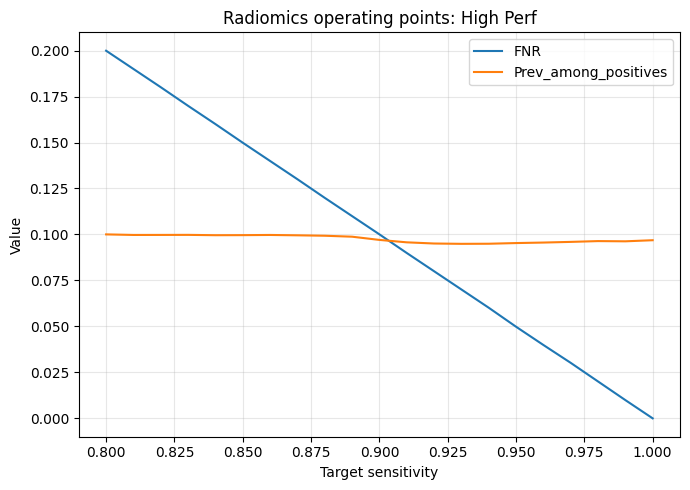

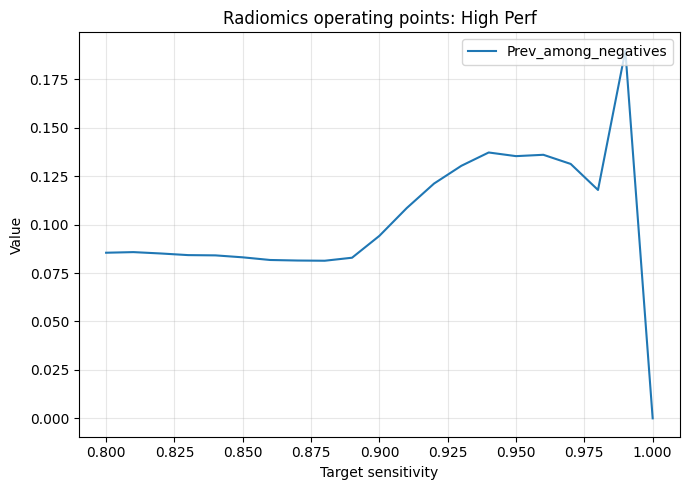

In [16]:
# %%
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(op_grid["sens_target"], op_grid["FNR"], label="FNR", linewidth=1.5)
plt.plot(op_grid["sens_target"], op_grid["Prev_pos"], label="Prev_among_positives", linewidth=1.5)
plt.xlabel("Target sensitivity")
plt.ylabel("Value")
plt.title("Radiomics operating points: High Perf")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(op_grid["sens_target"], op_grid["Prev_neg"], label="Prev_among_negatives", linewidth=1.5)
plt.xlabel("Target sensitivity")
plt.ylabel("Value")
plt.title("Radiomics operating points: High Perf")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


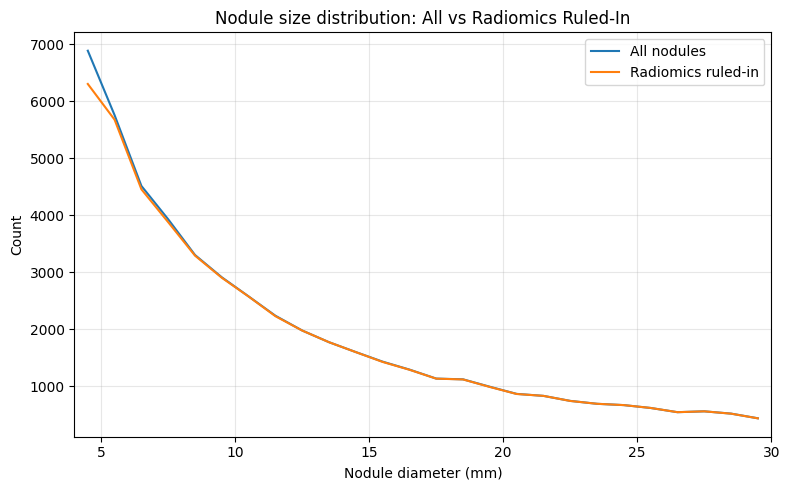

In [17]:
# %%
# Radiomics positive if score >= threshold at some chosen sens_target, e.g. 0.98
thr_98 = op_98["threshold"]
test_pos = scores_arr >= thr_98

df_all = pd.DataFrame({
    "size_mm": size_all_orig,
    "group": "All nodules"
})

df_in = pd.DataFrame({
    "size_mm": size_all_orig[test_pos],
    "group": "Radiomics ruled-in"
})

df_den = pd.concat([df_all, df_in], ignore_index=True)

plt.figure(figsize=(8,5))
for group, df_g in df_den.groupby("group"):
    counts, bin_edges = np.histogram(df_g["size_mm"], bins=np.arange(4, 31, 1))
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, counts, label=group, linewidth=1.5)

plt.xlabel("Nodule diameter (mm)")
plt.ylabel("Count")
plt.title("Nodule size distribution: All vs Radiomics Ruled-In")
plt.xlim(4, 30)
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [18]:
# %%
median_cut = 8.0  # as you forced in R
idx_large = np.where(size_all_orig >= median_cut)[0]
idx_small = np.where(size_all_orig < median_cut)[0]

idx_rulein = np.where(test_pos)[0]
idx_ruleout = np.where(~test_pos)[0]

is_cancer = (cancer_all == 1)

prev_rulein = is_cancer[idx_rulein].mean()
prev_ruleout_Rad = is_cancer[idx_ruleout].mean()
prev_large = is_cancer[idx_large].mean()
prev_small = is_cancer[idx_small].mean()

n_rulein  = len(idx_rulein)
n_ruleout = len(idx_ruleout)
n_large   = len(idx_large)
n_small   = len(idx_small)

summary = pd.DataFrame({
    "Group": ["Radiomics Rule-In", "Radiomics Rule-Out", "> 8mm", "< 8mm"],
    "N": [n_rulein, n_ruleout, n_large, n_small],
    "Prevalence": np.round([prev_rulein, prev_ruleout_Rad, prev_large, prev_small], 3)
})
summary


,Group,N,Prevalence
0,Radiomics Rule-In,49177,0.096
1,Radiomics Rule-Out,823,0.118
2,> 8mm,28910,0.150
3,< 8mm,21090,0.023
